<a href="https://colab.research.google.com/github/edwin-19/TransformersLatest/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets
!pip install pytorch_lightning
!pip install torchmetrics
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
     |████████████████████████████████| 6.6 MB 53.6 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 61.1 MB/s 
     |████████████████████████████████| 212 kB 57.5 MB/s 
     |████████████████████████████████| 140 kB 48.4 MB/s 
     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 127 kB 51.9 MB/s 
     |████████████████████████████████| 144 kB 48.4 MB/s 
     |███████████████

In [2]:
batch_size = 128
lr = 5e-5
epochs = 5

# Import libraries
- Datasets imports

In [3]:
from datasets import load_dataset
from transformers import RobertaTokenizer, Data2VecTextForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import scikitplot as skplt
from torchmetrics import Accuracy, MatthewsCorrCoef

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
pl.seed_everything(42)

tokenizer = RobertaTokenizer.from_pretrained("facebook/data2vec-text-base")
model = Data2VecTextForSequenceClassification.from_pretrained("facebook/data2vec-text-base")

Global seed set to 42


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/data2vec-text-base were not used when initializing Data2VecTextForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing Data2VecTextForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Data2VecTextForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Data2VecTextForSequenceClassification were not initialized from the model checkpoint at facebook/data2vec-text-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dens

In [6]:
def preprocess_function(batch):
  return tokenizer(
      batch['text'], truncation=True, padding='max_length', max_length=64
  )

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset = encoded_dataset.rename_columns({'label': 'labels'})

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [7]:
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

# Create lightning data module

In [8]:
class TextLightningDataModule(pl.LightningDataModule):
  def __init__(self, encoded_dataset, batch_size=256):
    super(TextLightningDataModule, self).__init__()
    self.encoded_dataset = encoded_dataset
    self.batch_size = batch_size

  def setup(self, stage=None):
    self.train_dataset = self.encoded_dataset['train']
    self.test_dataset = self.encoded_dataset['test']

  def train_dataloader(self) -> DataLoader:
    return DataLoader(
        self.train_dataset, pin_memory=True,
        shuffle=True, batch_size=self.batch_size,
        num_workers=2
    )

  def val_dataloader(self) -> DataLoader:
    return DataLoader(
        self.test_dataset, pin_memory=True,
        shuffle=False, batch_size=self.batch_size,
        num_workers=2
    )

  def test_dataloader(self) -> DataLoader:
    return DataLoader(
        self.test_dataset, pin_memory=True,
        shuffle=False, batch_size=self.batch_size,
        num_workers=2
    )

In [9]:
datamodule = TextLightningDataModule(encoded_dataset)

# LightningModule

In [10]:
class TextRecogModule(pl.LightningModule):
  def __init__(self, model, num_class, lr=5e-5):
    super(TextRecogModule, self).__init__()

    self.model = model
    self.lr = lr

    self.train_acc = Accuracy()
    self.val_acc = Accuracy()

    self.test_acc = Accuracy()
    self.test_mcc = MatthewsCorrCoef(num_class)

  def forward(self, input_ids, attention_mask, labels=None):
    return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

  def training_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']

    loss = outputs.loss
    logits = outputs.logits

    self.train_acc(logits.argmax(dim=1), label)
    self.log('train_acc', self.train_acc, prog_bar=True)

    return loss

  def validation_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']
    
    val_loss = outputs.loss
    logits = outputs.logits

    self.val_acc(logits.argmax(dim=1), label)
    self.log('val_acc', self.val_acc, prog_bar=True)

    return val_loss

  def test_step(self, batch, batch_idx):
    outputs = self(**batch)
    label = batch['labels']

    logits = outputs.logits

    self.test_acc(logits.argmax(dim=1), label)
    self.test_mcc(logits.argmax(dim=1), label)

    self.log('test_acc', self.test_acc, prog_bar=True, logger=True)
    self.log('test_mcc', self.test_mcc, prog_bar=True, logger=True)

    return {
        'acc': self.test_acc,
        'mcc': self.test_mcc
    }

  def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
    return {
        'logits': self(**batch),
        'gt': batch['labels']
    }

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)

    return {
        'optimizer': optimizer
    }

In [11]:
text_recog_module = TextRecogModule(model, encoded_dataset['train']['labels'].unique().size()[0])

# Create traininer & callbacks

In [12]:
# Define callbacks
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.02,
    patience=3,
    verbose=False,
    mode='max'
)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator='gpu', devices=1,
    callbacks=[early_stopping]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(text_recog_module, datamodule=datamodule)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                  | Params
--------------------------------------------------------------------
0 | model     | Data2VecTextForSequenceClassification | 124 M 
1 | train_acc | Accuracy                              | 0     
2 | val_acc   | Accuracy                              | 0     
3 | test_acc  | Accuracy                              | 0     
4 | test_mcc  | MatthewsCorrCoef                      | 0     
--------------------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.589   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
!nvidia-smi

Thu Jun  2 17:01:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    40W /  70W |   1430MiB / 15109MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Evaluate model

In [19]:
from sklearn.metrics import classification_report, matthews_corrcoef

In [15]:
preds = trainer.predict(text_recog_module, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 98it [00:00, ?it/s]

In [16]:
y_true = []
y_pred = []

for result in preds:
  y_true.append(result['gt'].detach().cpu().numpy())
  y_pred.append(result['logits'].logits.detach().cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [20]:
print(classification_report(y_true, y_pred.argmax(axis=1), target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.79      0.85      0.82     12500
    positive       0.84      0.78      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



In [21]:
print(matthews_corrcoef(y_true, y_pred.argmax(axis=1)))

0.6352768934101533


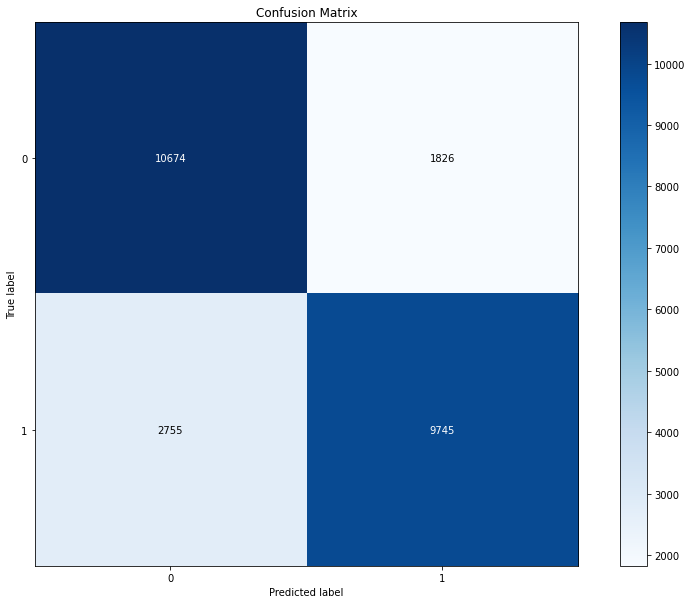

In [22]:
skplt.metrics.plot_confusion_matrix(y_true, y_pred.argmax(axis=1), figsize=(15, 10))

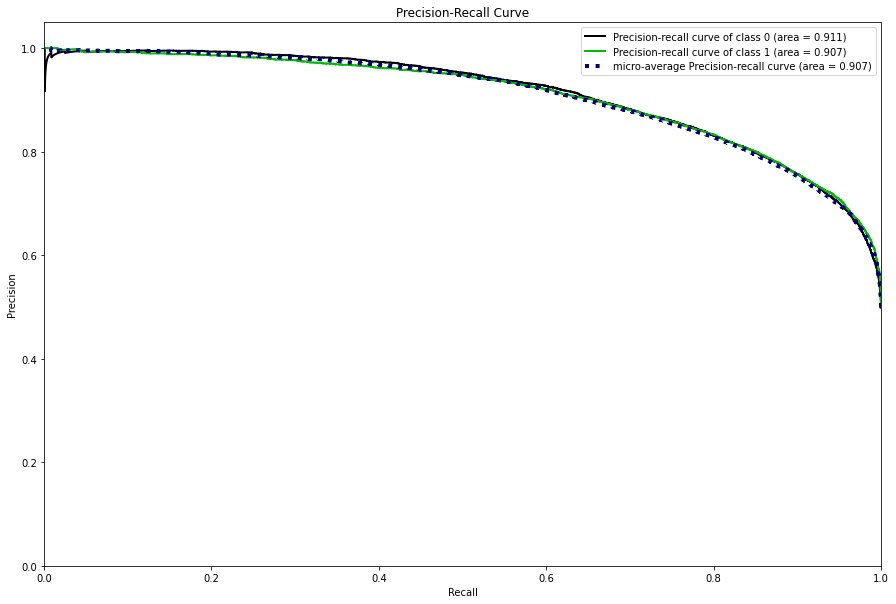

In [23]:
skplt.metrics.plot_precision_recall(y_true, y_pred, figsize=[15, 10])

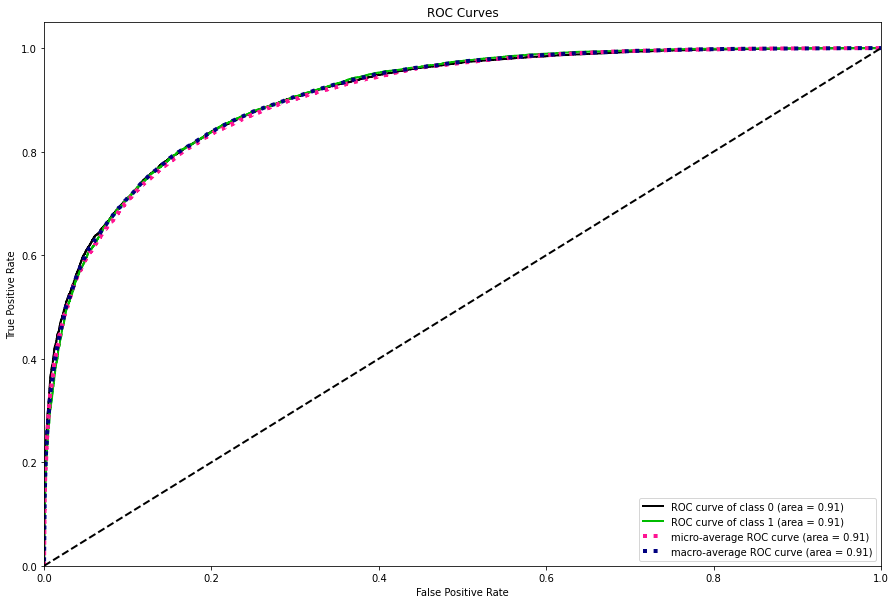

In [24]:
skplt.metrics.plot_roc(y_true, y_pred, figsize=[15, 10])

# Inference

In [28]:
label_map = {
    0: 'negative',
    1: 'positive'
}

In [25]:
with torch.no_grad():
  results = model(**tokenizer(
      'To hell with this', return_tensors='pt', truncation=True, padding='max_length', max_length=64
  ))

In [33]:
pred = results.logits

'Label: {}, Conf: {}'.format(label_map[pred.argmax(axis=1).item()], F.softmax(pred, dim=1).amax(dim=1).item())

'Label: negative, Conf: 0.9277012944221497'